# Imports

In [1]:
import os
os.chdir("D:\PulpitE\FPL_ML")

In [2]:
import pandas as pd

import torch
import torch.nn as nn

import torchvision
import torchvision.transforms

from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

import matplotlib.pyplot as plt

import numpy as np
import random

# Constants and seeds

In [3]:
# FIXTURES_IN_SAMPLE
FIS = 8
# FIXTURES_FOR_PLAYER
FFP = 15

In [4]:
def set_all_seeds(seed):
    os.environ["PL_GLOBAL_SEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

set_all_seeds(42)

# Data

In [5]:
df = pd.read_csv('data/fpl_fbref_players.csv')

In [6]:
info = ["Name", "GW"]
other = ["LSTM"]
features = ["Min", "Gls", "Sh", "SoT", "xG", "npxG", "xAG", "CS", "Was Home"]
to_predict = ["FPL"]

In [7]:
df = df[info + features + to_predict]
df[features + to_predict] = df[features + to_predict].astype("float32")

In [8]:
df.shape

(6104, 12)

In [9]:
# removing NaN rows and players that appear less than 15 times
df = df.dropna()
grouped = df.groupby('Name')
df = grouped.filter(lambda x: len(x) >= FFP)

In [10]:
df.shape

(4080, 12)

In [11]:
df.head(FFP)

,Name,GW,Min,Gls,Sh,SoT,xG,npxG,xAG,CS,Was Home,FPL
0,Brenden-Aaronson,4,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
1,Brenden-Aaronson,5,75.0,0.0,1.0,1.0,0.1,0.1,0.1,0.0,1.0,5.0
2,Brenden-Aaronson,6,90.0,0.0,1.0,0.0,0.0,0.0,0.3,0.0,0.0,2.0
3,Brenden-Aaronson,9,78.0,0.0,0.0,0.0,0.0,0.0,0.1,1.0,1.0,3.0
4,Brenden-Aaronson,10,75.0,0.0,2.0,0.0,0.1,0.1,0.0,0.0,0.0,2.0
5,Brenden-Aaronson,11,90.0,0.0,2.0,1.0,0.1,0.1,0.3,0.0,1.0,2.0
6,Brenden-Aaronson,12,90.0,0.0,1.0,0.0,0.1,0.1,0.4,0.0,0.0,2.0
7,Brenden-Aaronson,13,90.0,0.0,1.0,0.0,0.1,0.1,0.9,0.0,1.0,2.0
8,Brenden-Aaronson,14,90.0,0.0,2.0,0.0,0.2,0.2,0.2,0.0,0.0,2.0
9,Brenden-Aaronson,15,85.0,0.0,2.0,0.0,0.1,0.1,0.0,0.0,1.0,2.0


In [12]:
last_names = df["Name"].unique()

# DF to DataLoader

In [13]:
def split_indices(index):
    return (index // (FFP-FIS)), (index % (FFP-FIS))

In [14]:
split_indices(11)

(1, 4)

In [15]:
from torchvision.transforms import ToTensor

class PandasDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe
        self.names = dataframe["Name"].unique()
        self.transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

    def __len__(self):
        return len(self.names) * (FFP-FIS)

    def __getitem__(self, idx):
        # print(idx)
        player_id, sample_id = split_indices(idx)
        name = self.names[player_id]
        # print(name)
        features = self.dataframe[self.dataframe["Name"] == name]
        # print(self.dataframe[self.dataframe["Name"] == name])
        # print(features[sample_id: (sample_id + 4)])
        features = features[sample_id: (sample_id + FIS - 1)].drop(columns=info).values[:, :-1]
        # print(features)
        # print(features)
        # print(type(features))
        # print(self.dataframe[self.dataframe["Name"] == name].values[:, -1])
        # print(type(self.dataframe[self.dataframe["Name"] == name].values[:, -1]))
        # target = self.dataframe[self.dataframe["Name"] == name].values[:, -1]
        # target = target.astype(np.float32)
        # target = torch.from_numpy(target)
        target = np.float32(self.dataframe[self.dataframe["Name"] == name].values[(sample_id + FIS), -1])
        # print(name, idx, target, sample_id)
        # print(type(target))
        return features, target

In [16]:
dataset = PandasDataset(df)
dataset.__getitem__(5)

(array([[90. ,  0. ,  2. ,  1. ,  0.1,  0.1,  0.3,  0. ,  1. ],
        [90. ,  0. ,  1. ,  0. ,  0.1,  0.1,  0.4,  0. ,  0. ],
        [90. ,  0. ,  1. ,  0. ,  0.1,  0.1,  0.9,  0. ,  1. ],
        [90. ,  0. ,  2. ,  0. ,  0.2,  0.2,  0.2,  0. ,  0. ],
        [85. ,  0. ,  2. ,  0. ,  0.1,  0.1,  0. ,  0. ,  1. ],
        [90. ,  0. ,  2. ,  0. ,  0.1,  0.1,  0.4,  0. ,  0. ],
        [82. ,  0. ,  1. ,  0. ,  0. ,  0. ,  0. ,  0. ,  1. ]],
       dtype=float32),
 2.0)

In [17]:
batch_size = 16

In [18]:
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [19]:
next(iter(dataloader))[1]

tensor([2., 2., 5., 2., 3., 2., 2., 1., 2., 2., 7., 2., 2., 2., 2., 2.])

# LSTM Model

In [20]:
class LSTMNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(LSTMNetwork, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.transpose(x, 0, 1)
        # x = x.view(-1, batch_size)
        # x = torch.transpose(x, 0, 1)
        # print("FOR", x.shape)
        # print(x.shape)
        # print(x.shape)
        out, _ = self.lstm(x)
        # print(out.shape)
        out = self.fc(out[-1])
        return out

In [21]:
len(dataloader)

119

In [22]:
torch.transpose(next(iter(dataloader))[0], 0, 1).shape

torch.Size([7, 16, 9])

In [23]:
net = LSTMNetwork(1, 20, 2, 1, dropout=0.4)

# Training loop

In [24]:
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.005)

In [25]:
%%time
num_epochs =10
loss_history = []
for epoch in range(num_epochs):
    running_loss = 0
    for i, (inputs, targets) in enumerate(dataloader):
        inputs = torch.flatten(inputs, 1, 2)
        inputs = inputs.unsqueeze(2)
        # print("INPUTS", inputs.shape)
        # print("TARGETS", targets.shape)
        # print(targets)
        optimizer.zero_grad()
        outputs = net(inputs).flatten()
        # print("OUTPUTS", outputs.shape)
        loss = criterion(outputs, targets)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
    
    loss_history.append(running_loss / len(dataloader))
    if epoch % 5 == 0:
        print(f'Epoch {epoch} Loss: {running_loss / len(dataloader)}')

Epoch 0 Loss: 4.085616135296702
Epoch 5 Loss: 3.3496561030379866
CPU times: total: 4min 49s
Wall time: 1min 21s


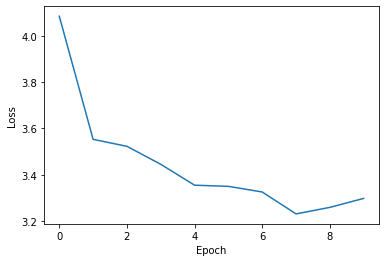

In [26]:
plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Predictions

In [29]:
index = 0
predictions = []
for inputs, target in dataloader:
    inputs = torch.flatten(inputs, 1, 2)
    inputs = inputs.unsqueeze(2)
    # print("INPUTS", inputs)
    # print(inputs)
    outputs = net(inputs)
    # print("OUTPUTS", outputs)
    for output in outputs:
        player_id, sample_id = split_indices(index)
        name = last_names[player_id]
        points = round(output.item(), 2)
        gw = sample_id + FIS + 1
        predictions.append([name, gw, points])
        # df.loc[(df["Name"] == name) & (df["GW"] == gw), "LSTM"] = points
        index += 1

In [34]:
# appending results
for name, gw, points in predictions:
    df.loc[(df["Name"] == name) & (df["GW"] == gw), "LSTM"] = points

In [43]:
df.loc[df['LSTM'].notnull()]

,Name,GW,Min,Gls,Sh,SoT,xG,npxG,xAG,CS,Was Home,FPL,LSTM
3,Brenden-Aaronson,9,78.0,0.0,0.0,0.0,0.0,0.0,0.1,1.0,1.0,3.0,2.95
4,Brenden-Aaronson,10,75.0,0.0,2.0,0.0,0.1,0.1,0.0,0.0,0.0,2.0,3.01
5,Brenden-Aaronson,11,90.0,0.0,2.0,1.0,0.1,0.1,0.3,0.0,1.0,2.0,3.11
6,Brenden-Aaronson,12,90.0,0.0,1.0,0.0,0.1,0.1,0.4,0.0,0.0,2.0,3.29
7,Brenden-Aaronson,13,90.0,0.0,1.0,0.0,0.1,0.1,0.9,0.0,1.0,2.0,3.77
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6095,Martin-Odegaard,10,81.0,0.0,2.0,1.0,0.3,0.3,0.5,0.0,1.0,5.0,4.23
6096,Martin-Odegaard,11,72.0,0.0,4.0,2.0,0.2,0.2,0.2,1.0,0.0,6.0,4.36
6097,Martin-Odegaard,13,82.0,0.0,1.0,0.0,0.1,0.1,0.4,0.0,0.0,2.0,3.85
6098,Martin-Odegaard,14,90.0,1.0,3.0,1.0,0.2,0.2,0.6,1.0,1.0,8.0,4.36


In [28]:
# results sorted
pd.DataFrame(predictions, columns=["Name", "GW", "Points"]).sort_values(by=["Points"], ascending = False).head(20)

,Name,GW,Points
771,Erling-Haaland,10,4.65
1209,Aleksandar-Mitrovic,14,4.62
1518,Mohamed-Salah,15,4.62
58,Miguel-Almiron,11,4.62
774,Erling-Haaland,13,4.61
1506,Bukayo-Saka,10,4.60
1738,Leandro-Trossard,11,4.59
776,Erling-Haaland,15,4.59
1903,Martin-Odegaard,15,4.59
173,Harvey-Barnes,14,4.58
